<a href="https://colab.research.google.com/github/devWorldDivey/KaggleNotebooks/blob/main/Predict_TaxiFarePrice_using_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow
import pandas as pd

In [4]:
df = pd.read_csv('/content/taxifare.csv', parse_dates=['pickup_datetime'])
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2014-06-15 17:11:00.000000107,7.0,2014-06-15 17:11:00+00:00,-73.995420,40.759662,-73.987607,40.751247,1
1,2011-03-14 22:43:00.00000095,4.9,2011-03-14 22:43:00+00:00,-73.993552,40.731110,-73.998497,40.737200,5
2,2011-02-14 15:14:00.00000067,6.1,2011-02-14 15:14:00+00:00,-73.972380,40.749527,-73.990638,40.745328,1
3,2009-10-29 11:29:00.00000040,6.9,2009-10-29 11:29:00+00:00,-73.973703,40.763542,-73.984253,40.758603,5
4,2011-07-02 10:38:00.00000028,10.5,2011-07-02 10:38:00+00:00,-73.921262,40.743615,-73.967383,40.765162,1


In [6]:
from math import sqrt

df = df[df['passenger_count'] == 1]
df = df.drop(['key', 'passenger_count'], axis=1)

for i, row in df.iterrows():
    dt = row['pickup_datetime']
    df.at[i, 'day_of_week'] = dt.weekday()
    df.at[i, 'pickup_time'] = dt.hour
    x = (row['dropoff_longitude'] - row['pickup_longitude']) * 54.6
    y = (row['dropoff_latitude'] - row['pickup_latitude']) * 69.0
    distance = sqrt(x**2 + y**2)
    df.at[i, 'distance'] = distance

df.drop(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
         'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)

df = df[(df['distance'] > 1.0) & (df['distance'] < 10.0)]
df = df[(df['fare_amount'] > 0.0) & (df['fare_amount'] < 50.0)]
df.head()


,fare_amount,day_of_week,pickup_time,distance
2,6.1,0.0,15.0,1.038136
4,10.5,5.0,10.0,2.924341
5,15.3,4.0,20.0,4.862893
8,7.7,5.0,1.0,2.603493
9,8.9,3.0,16.0,1.365739


##### Following statements to create a network with an input layer that accepts three values (day, time, and distance), two hidden layers with 512 neurons each, and an output layer with a single neuron (the predicted fare amount)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=3))
model.add(Dense(512, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               2048      
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 265,217
Trainable params: 265,217
Non-trainable params: 0
_________________________________________________________________


In [8]:
x = df.drop('fare_amount', axis=1)
y = df['fare_amount']

hist = model.fit(x, y, validation_split=0.2, epochs=100, batch_size=100)

Epoch 1/100
187/187 [==============================] - 3s 10ms/step - loss: 2.8993 - mae: 2.8993 - val_loss: 2.3827 - val_mae: 2.3827
Epoch 2/100
187/187 [==============================] - 2s 9ms/step - loss: 2.3961 - mae: 2.3961 - val_loss: 2.3727 - val_mae: 2.3727
Epoch 3/100
187/187 [==============================] - 3s 16ms/step - loss: 2.3759 - mae: 2.3759 - val_loss: 2.3546 - val_mae: 2.3546
Epoch 4/100
187/187 [==============================] - 2s 10ms/step - loss: 2.3806 - mae: 2.3806 - val_loss: 2.3609 - val_mae: 2.3609
Epoch 5/100
187/187 [==============================] - 2s 10ms/step - loss: 2.3806 - mae: 2.3806 - val_loss: 2.3669 - val_mae: 2.3669
Epoch 6/100
187/187 [==============================] - 2s 10ms/step - loss: 2.3844 - mae: 2.3844 - val_loss: 2.3737 - val_mae: 2.3737
Epoch 7/100
187/187 [==============================] - 2s 9ms/step - loss: 2.3708 - mae: 2.3708 - val_loss: 2.3542 - val_mae: 2.3542
Epoch 8/100
187/187 [==============================] - 2s 10ms/s

[]

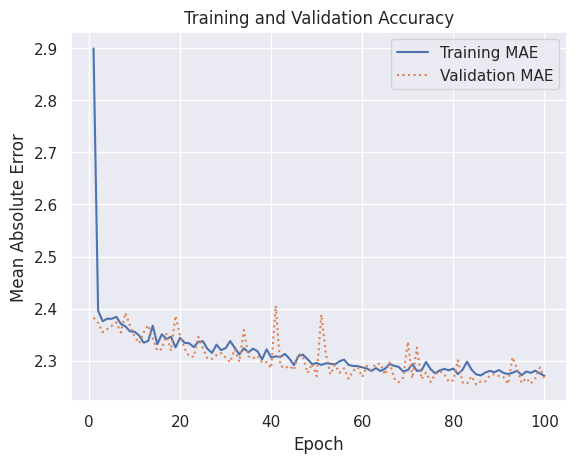

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

err = hist.history['mae']
val_err = hist.history['val_mae']
epochs = range(1, len(err) + 1)

plt.plot(epochs, err, '-', label='Training MAE')
plt.plot(epochs, val_err, ':', label='Validation MAE')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='upper right')
plt.plot()

In [10]:
from sklearn.metrics import r2_score

r2_score(y, model.predict(x))

729/729 [==============================] - 4s 5ms/step


0.7449175360907118

### what it will cost to hire a taxi for a 2-mile trip at 5:00 p.m. on Friday

In [11]:
import numpy as np

model.predict(np.array([[4, 17, 2.0]]))

1/1 [==============================] - 0s 379ms/step


array([[10.761321]], dtype=float32)

### predict the fare amount for a 2-mile trip taken at 5:00 p.m. one day later (on Saturday)

In [12]:
model.predict(np.array([[5, 17, 2.0]]))

1/1 [==============================] - 0s 25ms/step


array([[10.574879]], dtype=float32)